In [7]:
# Subject 4: latency and capacity estimation for a network connection from asymmetric measurements
# What we are interested in here is the mean time required for sending a message of a given length.

In [ ]:
# Our tasks
# 1) Start by working on the first dataset (liglab2). Plot the time evolution of transmission time, if useful at different moments in time and/or on different time scales, in order to evaluate the temporal stability of the phenomenon. Can the variations be explained solely by message size?
# 2) Plot the transmission time as a function of message size. You should observe a "disruption", a size starting from which the variability changes qualitatively. Estimate this time graphically, in order to treat the two classes of message size separately.
# 3) Perform a linear regression for each class and estimate the corresponding values of L and C. Superpose the result of this regression onto the preceding plot.

In [9]:
# Let start trying to read the input file "liglab2.log" and take the values we need.
# [1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [7]:
file = open('liglab2.log','r')
#for lines in file:
    #print(lines)

In [ ]:
# Verifying if we have invalid lines, eg. messages that was not received.

In [123]:
file = open('liglab2.log','r')
invalidLines = 0
validLines = 0
for lines in file:
    values = lines.split()
    if(len(values) < 10): #10 is the size of a full row
        invalidLine += 1
    else:
        validLines += 1 
print("Total valid lines: " + str(totalLines))
print("Total invalid lines: " + str(invalidLine))

Total valid lines: 44036
Total invalid lines: 1131


In [2]:
# Start by working on the first dataset (liglab2). Plot the time evolution of transmission time, 
# if useful at different moments in time and/or on different time scales, in order to evaluate 
# the temporal stability of the phenomenon. Can the variations be explained solely by message size?

#[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms

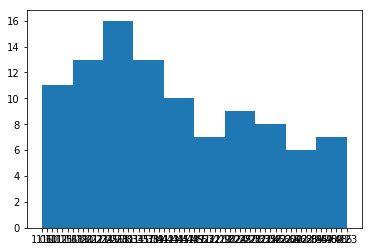

In [229]:
file = open('liglab2.log','r')
times = []
sizes = []
for lines in file:
    values = lines.split()
    if(len(values) == 10):
        times.append(values[8].split('=')[1])
        sizes.append(values[1])
dimension = 100
index =  np.random.choice(validLines,dimension, replace = False)
t = []
for i in range (dimension) :
    t.append(times[index[i]])
#print(t)
t = sorted(t)
plt.hist(t)
plt.show()

